# Adaptive Stochastic Gradient Descent

Implementation and comparison of adaptive stochastic gradient descent methods using Python and TensorFlow framework. The efficiency comparison is demonstrated in the neural language processing problem.

## Introduction

The gradient descent method is a key algorithm in backpropagation optimization for neural networks. Aside hyperparameter tuning, there are various ways to improve the efficiency and speed of learning like, for instance, applying **momentum** to the gradient or by using batching.

In this overview, the following gradient algorithms will be implemented using TensorFlow API to speed up the process of gradient calculation in the neural language processing problem using [Calculation Graph](https://www.tensorflow.org/api_docs/python/tf/Graph).

In [1]:
import tensorflow as tf

## Tensorflow API usage

The gradient value for the following methods will be calculated using [tf.GradientTape()](https://www.tensorflow.org/api_docs/python/tf/GradientTape) in order to achieve higher performance and calculation parallelism. The following code demonstrates class usage in the optimization problem for the **Rosenbrock function**:

$F(x, y) = (1 - x)^{2} + 100(y - x^{2})^{2}$

Function has a single local minimum in $(1, 1)$ and is equal $0$ in the following point.

The gradient value, by definition, is a vector that points towards the direction of the greatest increase of the function. In order to reach a local minimum using an iterative algorithm, the next step should be in the direction opposite to the gradient value. So the full algorithm of finding local minimum can be described as $x_{i+1} = x_{i} - \lambda_{i}\nabla F$, where $\lambda_{i} = const$ - size of a single step, $x_{i}$ - current step.

In [2]:
# Single iteration of an algorithm
def gradient_step(alpha: tf.constant, x: tf.Variable, y: tf.Variable) -> tf.Variable:
  with tf.GradientTape() as grad:
    grad.watch((alpha, x, y))

    # Optimization function
    F = (1.0 - x) ** 2.0 + 100.0 * (y - x ** 2.0) ** 2.0
    [dF_dx, dF_dy] = grad.gradient(F, [x, y])

  return x - alpha * tf.Variable(dF_dx), y - alpha * tf.Variable(dF_dy)

# Gradient steps
steps = 1000

# Gradient step size
alpha = tf.constant(0.001)

# Start conditions
x = tf.Variable(2.0)
y = tf.Variable(-1.0)

# Iterations
xy = []

for _ in range(steps):
  # Iterative descent
  x, y = gradient_step(alpha, x, y)

  xy.append((x.numpy(), y.numpy()))

print(f"Closest approximation of the local minimum: {xy[-1]}")

Closest approximation of the local minimum: (0.9669684, 0.9348931)


Using [matplotlib](https://matplotlib.org/) library, all recorded steps $\{ x_{1}, x_{n} \}$ can be visualised in a following 3D plot.

In [3]:
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm as cmap
from numpy import arange, meshgrid

Visualisation intervals and rendering density

In [4]:
density = 0.1

X = arange(-2.0, 2.0, density)
Y = arange(-1.0, 3.0, density)

X, Y = meshgrid(X, Y)

**Rosenbrock function** in vector form:

In [5]:
F = (1.0 - X) ** 2.0 + 100.0 * (Y - X ** 2.0) ** 2.0

Descent visualisation for space: $\{ -2 \leq x \leq 2; -1 \leq y \leq 3 \}$

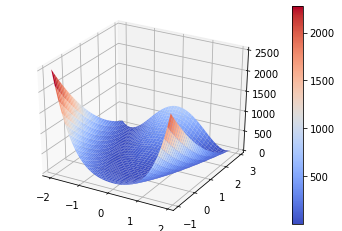

In [6]:
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X, Y, F, cmap=cmap, antialiased=True)
fig.colorbar(surf)

plt.show()

## Attribution

Overview is based on research paper "An overview of gradient descent optimization algorithms" from [arXiv.org](https://arxiv.org/pdf/1609.04747.pdf) by [Sebastian Ruder](mailto:ruder.sebastian@gmail.com) licensed under CC BY-NC-SA 4.0.